# Importing Dependencies

In [ ]:
!pip install lime
!pip install colorama
!pip install opencv-python
!git clone https://github.com/CraigList056/assets.git
!git clone https://github.com/samson6460/tf_keras_gradcamplusplus.git ./assets/tf_keras_gradcamplusplus

# Download assets from the GitHub repository
# !apt install subversion
# !svn checkout https://github.com/tariqshaban/disaster-classification-with-xai/trunk/assets

import os
import sys
import re
import random
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from colorama import Fore, Style
from PIL import Image, ImageFile
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Layer
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.preprocessing import image
from glob import glob
from assets.tf_keras_gradcamplusplus.utils import preprocess_image
from assets.tf_keras_gradcamplusplus.gradcam import grad_cam, grad_cam_plus
from IPython.display import clear_output

clear_output()
print(Fore.GREEN + u'\u2713 ' + 'Successfully downloaded dependencies.')
print(Style.RESET_ALL)

✓ Successfully downloaded dependencies.



In [ ]:
class IgnorePrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Global Variables

In [ ]:
CLASSES = ('accident_human_inflicted',
           'earthquake',
           'el_niño',
           'flood',
           'infrastructure_damage',
           'landslide',
           'no_damage_buildings_street',
           'no_damage_human',
           'no_damage_water_related',
           'no_damage_wildlife_forest',
           'urban_fire',
           'wild_fire')

SEED = 68765

TRAIN_SPLIT = 0.7
VALID_SPLIT = 0.2
TEST_SPLIT = 0.1

IMAGE_SHAPE_2D = (224, 224)
IMAGE_SHAPE_3D = (224, 224, 3)

SOURCE_DIRECTORY = './assets/disaster_data/'
REFACTORED_DIRECTORY = './assets/refactored_data/'
TRAIN_DIRECTORY = './assets/refactored_data/train/'
VALID_DIRECTORY = './assets/refactored_data/valid/'
TEST_DIRECTORY = './assets/refactored_data/tests/'

EPOCHS = 50
# LEARNING_RATE = 0.1
# LEARNING_RATE = 0.01
LEARNING_RATE = 0.001

BASE_MODEL = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.resnet50.preprocess_input

# BASE_MODEL = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
# PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.inception_v3.preprocess_input

# BASE_MODEL = VGG19(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
# PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.vgg19.preprocess_input

# BASE_MODEL = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
# PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.efficientnet.preprocess_input

# BASE_MODEL = EfficientNetB7(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
# PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.efficientnet.preprocess_input

# BASE_MODEL = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
# PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input

# BASE_MODEL = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
# PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input

OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
# OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

94765736/94765736 [==============================] - 3s 0us/step


# Helper Methods

#### Prime Dataset

In [ ]:
def prime_dataset():
  # Read Each Image With its Class Label
  images = []
  folders=CLASSES

  for folder in folders:
    t = folder
    x = !ls $SOURCE_DIRECTORY$t
    for i in x:
      for j in re.split(r'[-;,\t\s]\s*', i):
        if j == '':
          continue
        images.append({'Class':t,'Image':j})


  # Partition Images into Traning, Validation, and Testing
  for c in folders:
      os.makedirs(f'{TRAIN_DIRECTORY}{c}', exist_ok=True)
      os.makedirs(f'{VALID_DIRECTORY}{c}', exist_ok=True)
      os.makedirs(f'{TEST_DIRECTORY}{c}', exist_ok=True)

  counter=0
  for c in folders:
      numOfFiles = len(next(os.walk(f'{SOURCE_DIRECTORY}{c}/'))[2])
      for files in random.sample(glob(f'{SOURCE_DIRECTORY}{c}/*'), int(numOfFiles*TRAIN_SPLIT)):
          shutil.move(files, f'{TRAIN_DIRECTORY}{c}')

      for files in random.sample(glob(f'{SOURCE_DIRECTORY}{c}/*'), int(numOfFiles*VALID_SPLIT)):
          shutil.move(files, f'{VALID_DIRECTORY}{c}')

      for files in glob(f'{SOURCE_DIRECTORY}{c}/*'):
          shutil.move(files, f'{TEST_DIRECTORY}{c}')
      counter+=1

  shutil.rmtree(SOURCE_DIRECTORY)

#### Build Model

In [ ]:
def build_model(measure_performance:bool = True):
  ImageFile.LOAD_TRUNCATED_IMAGES = True

  train_batches = ImageDataGenerator(preprocessing_function=PREPROCESSING_METHOD).flow_from_directory(directory=TRAIN_DIRECTORY, target_size=IMAGE_SHAPE_2D, classes=CLASSES, batch_size=128)
  valid_batches = ImageDataGenerator(preprocessing_function=PREPROCESSING_METHOD).flow_from_directory(directory=VALID_DIRECTORY, target_size=IMAGE_SHAPE_2D, classes=CLASSES, batch_size=128, shuffle=False)
  test_batches =  ImageDataGenerator(preprocessing_function=PREPROCESSING_METHOD).flow_from_directory(directory=TEST_DIRECTORY, target_size=IMAGE_SHAPE_2D, classes=CLASSES, batch_size=128, shuffle=False)

  input_shape = IMAGE_SHAPE_3D
  nclass = len(CLASSES)
  epoch = EPOCHS
  base_model = BASE_MODEL
  base_model.trainable = False

  add_model = Sequential()
  add_model.add(base_model)
  add_model.add(Layer())
  add_model.add(GlobalAveragePooling2D())
  add_model.add(Dropout(0.5))
  add_model.add(Dense(nclass, activation='softmax'))

  model = add_model
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1 ,  patience = 10)


  fitted_model= model.fit(x=train_batches, validation_data=valid_batches, epochs=epoch, callbacks=[es])
  score, accuracy = model.evaluate(x=test_batches, batch_size=128)

  print(Fore.GREEN + u'\n\u2713 ' + f'Accuracy ==> {accuracy}')
  print(Fore.GREEN + u'\n\u2713 ' + f'Loss ==> {score}')

  plt.rcParams["figure.figsize"] = (15,8)

  if measure_performance:
    plt.plot(fitted_model.history['accuracy'])
    plt.plot(fitted_model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(fitted_model.history['loss'])
    plt.plot(fitted_model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    y_pred = model.predict(test_batches)


    ax = sns.heatmap(confusion_matrix(test_batches.classes, y_pred.argmax(axis=1)), annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    ax.xaxis.set_ticklabels(CLASSES)
    ax.yaxis.set_ticklabels(CLASSES)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


    labels = {value: key for key, value in train_batches.class_indices.items()}
    print("Label Mappings for classes present in the training and validation datasets\n")
    for key, value in labels.items():
      print(f"{key} : {value}")

    print(classification_report(test_batches.classes, y_pred.argmax(axis=1), target_names=labels.values()))


  return model

#### Predict Image Class

In [ ]:
def predict_image_class(img, model):
  img = np.expand_dims(img, axis=0)
  preprocessed_image = image_preprocess(img)
  tensor = tf.convert_to_tensor(preprocessed_image, dtype=tf.float32)

  label = CLASSES[np.argmax(model.predict(tensor))]

  sys.stdout.write(Fore.GREEN + u'\n\u2713 ' + f'Model Output ==> '),
  if label == 'el_niño':
    sys.stdout.write('El Niño')
  elif label == 'earthquake':
    sys.stdout.write('Earthquake')
  elif label == 'accident_human_inflicted':
    sys.stdout.write('Accident / Human Inflicted')
  elif label == 'infrastructure_damage':
    sys.stdout.write('Infrastructure Damage')
  elif label == 'landslide':
    sys.stdout.write('Landslide')
  elif label == 'no_damage_buildings_street':
    sys.stdout.write('No Damage (Buildings / Street)')
  elif label == 'no_damage_human':
    sys.stdout.write('No Damage (Human)')
  elif label == 'no_damage_water_related':
    sys.stdout.write('No Damage (Water-Related)')
  elif label == 'no_damage_wildlife_forest':
    sys.stdout.write('No Damage (Wildlife / Forest)')
  elif label == 'urban_fire':
    sys.stdout.write('Urban Fire')
  elif label == 'flood':
    sys.stdout.write('Flood')
  else:
    sys.stdout.write('Wild Fire')

  print(Style.RESET_ALL)

#### Show Image

In [ ]:
def show_image(img):
  img = Image.fromarray(img)
  display(img)

#### URL to Image

In [ ]:
def url_to_image(url):
  image_url = tf.keras.utils.get_file(origin=url)
  img = image.load_img(image_url, target_size=IMAGE_SHAPE_2D)
  img = np.expand_dims(img, axis=0)
  return np.vstack([img])[0]

#### Get Image

In [ ]:
def path_to_image(image_name = None):
  for root, dirs, files in os.walk(REFACTORED_DIRECTORY):
          if image_name in files:
              image_name = os.path.join(root, image_name)
              break

  img = Image.open(image_name)
  img = img.resize(IMAGE_SHAPE_2D)
  img = np.expand_dims(img, axis=0)
  return np.vstack([img])[0]

#### Implement image preprocessing method

In [ ]:
def image_preprocess(img):
  return PREPROCESSING_METHOD(img)

#### Implement Lime XAI

In [ ]:
def explain_image_lime(img, model):
  # Temporarily disable output stream, preventing unnecesarry output
  with IgnorePrints():
      preprocessedImage = image_preprocess(img)

      explainer = lime_image.LimeImageExplainer()
      explanation = explainer.explain_instance(np.asanyarray(preprocessedImage).astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

      temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

  return mark_boundaries(img, mask)


#### Implemnt Grad-CAM XAI

In [ ]:
def show_imgwithheat(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img

In [ ]:
def explain_image_grad_cam(img, model):
  image_path = './assets/buffer.jpg'

  Image.fromarray(img).save(image_path)

  img = preprocess_image(image_path, target_size=IMAGE_SHAPE_2D)
  preprocessed_image = image_preprocess(img)

  heatmap = grad_cam(
    model, preprocessed_image,
    layer_name = model.layers[1].name,
  )

  img_arr = show_imgwithheat(image_path, heatmap)

  os.remove(image_path)

  return img_arr

#### Implemnt Grad-CAM++XAI

In [ ]:
def explain_image_grad_cam_plus_plus(img, model):
  image_path = './assets/buffer.jpg'

  Image.fromarray(img).save(image_path)

  img = preprocess_image(image_path, target_size=IMAGE_SHAPE_2D)
  preprocessed_image = image_preprocess(img)

  heatmap = grad_cam_plus(
    model, preprocessed_image,
    layer_name = model.layers[1].name,
  )

  show_imgwithheat(image_path, heatmap)

  img_arr = show_imgwithheat(image_path, heatmap)

  os.remove(image_path)

  return img_arr

#### Plot XAI

In [ ]:
def plot_XAI(img, model):
  plt.rcParams["figure.figsize"] = (10,10)
  fig, ax = plt.subplots(2,2)
  ax[0,0].imshow(img)
  ax[0,1].imshow(explain_image_lime(img, model))
  ax[1,0].imshow(explain_image_grad_cam(img, model))
  ax[1,1].imshow(explain_image_grad_cam_plus_plus(img, model))

  ax[0, 0].set_title("Original Image")
  ax[0, 1].set_title("LIME")
  ax[1, 0].set_title("Grad-CAM")
  ax[1, 1].set_title("Grad-CAM++")

  fig.tight_layout()
  plt.show()
  plt.rcParams["figure.figsize"] = (15,8)

# Methods Invocation

In [ ]:
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
prime_dataset()

Found 9484 images belonging to 12 classes.
Found 2707 images belonging to 12 classes.
Found 1365 images belonging to 12 classes.
Epoch 1/50
75/75 [==============================] - 89s 999ms/step - loss: 0.7832 - accuracy: 0.7783 - val_loss: 0.2781 - val_accuracy: 0.9106
Epoch 2/50
75/75 [==============================] - 66s 883ms/step - loss: 0.3316 - accuracy: 0.8973 - val_loss: 0.2203 - val_accuracy: 0.9294
Epoch 3/50
75/75 [==============================] - 64s 848ms/step - loss: 0.2641 - accuracy: 0.9170 - val_loss: 0.2034 - val_accuracy: 0.9335
Epoch 4/50
75/75 [==============================] - 64s 851ms/step - loss: 0.2264 - accuracy: 0.9272 - val_loss: 0.1995 - val_accuracy: 0.9365
Epoch 5/50
75/75 [==============================] - 64s 852ms/step - loss: 0.2071 - accuracy: 0.9338 - val_loss: 0.1960 - val_accuracy: 0.9368
Epoch 6/50
75/75 [==============================] - 63s 847ms/step - loss: 0.1893 - accuracy: 0.9385 - val_loss: 0.1950 - val_accuracy: 0.9383
Epoch 7/50
75

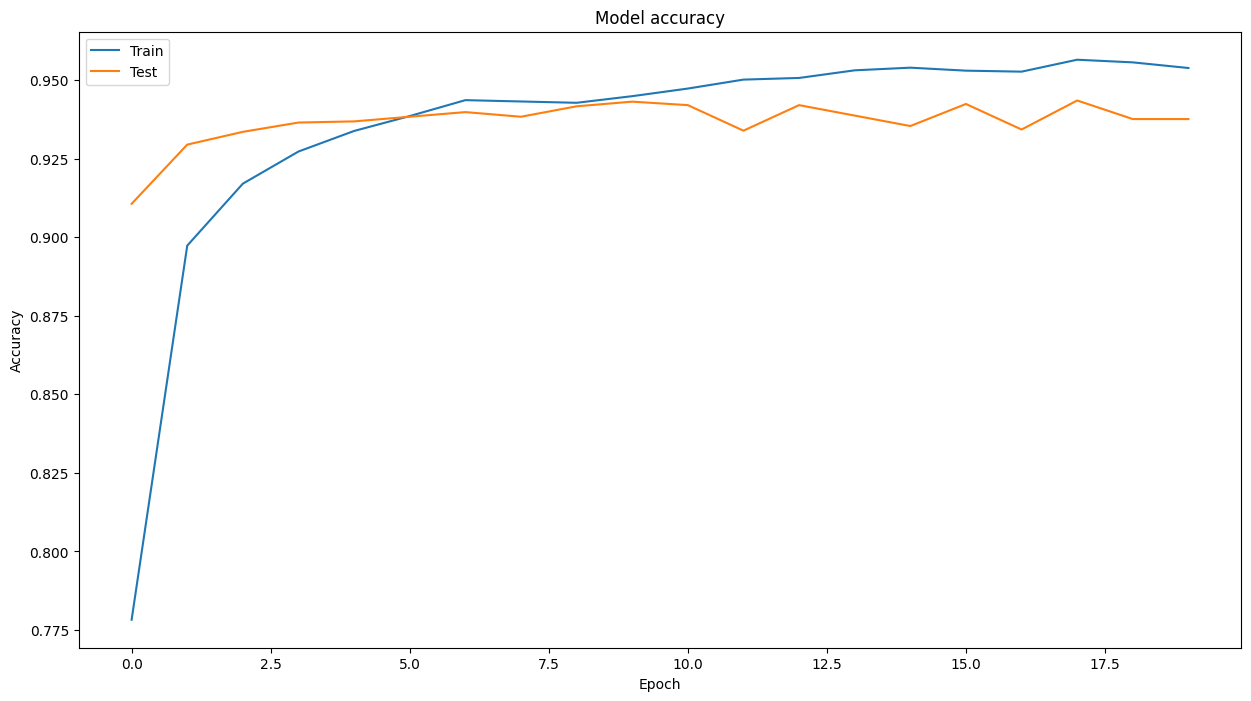

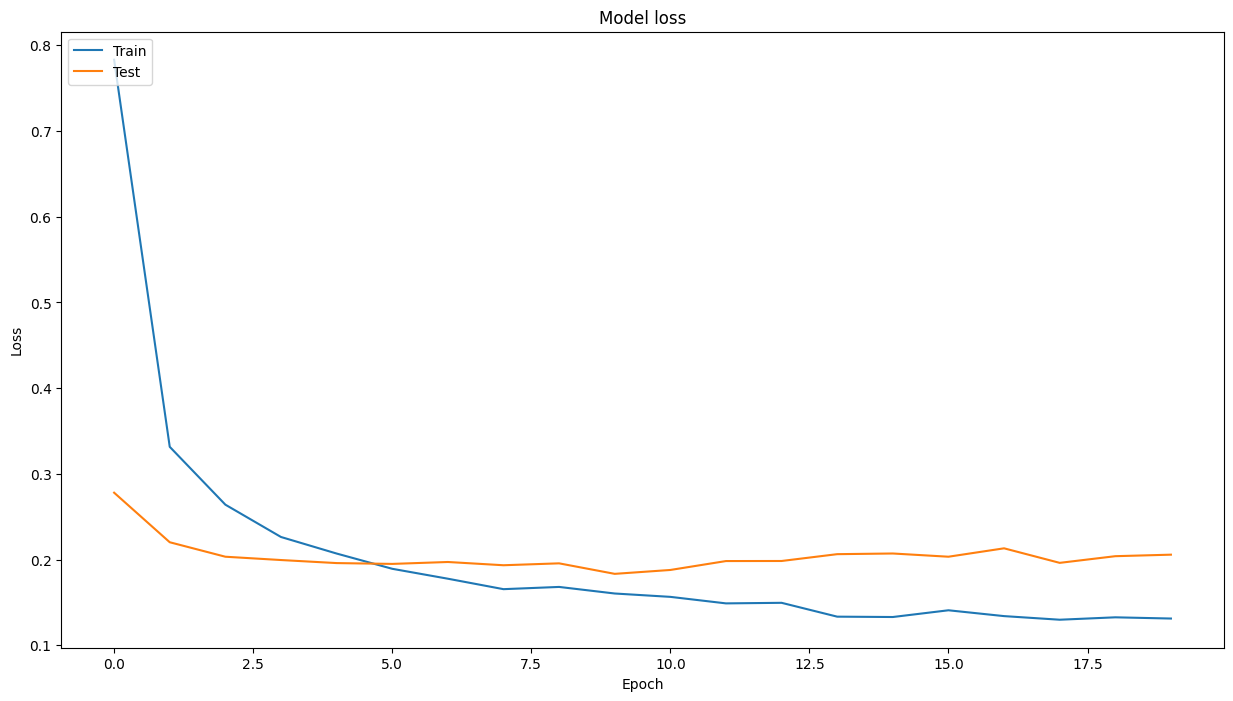

11/11 [==============================] - 9s 659ms/step


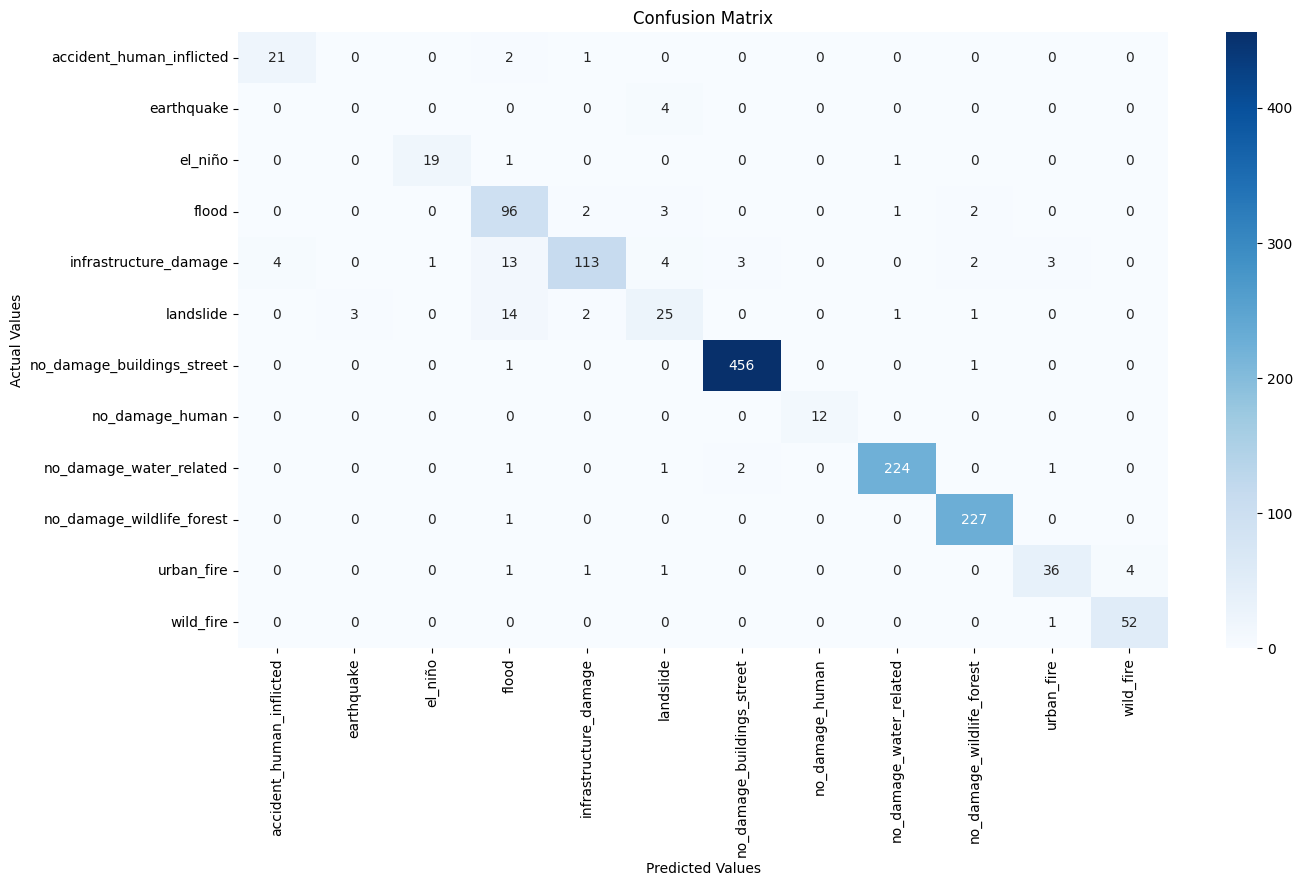

Label Mappings for classes present in the training and validation datasets

0 : accident_human_inflicted
1 : earthquake
2 : el_niño
3 : flood
4 : infrastructure_damage
5 : landslide
6 : no_damage_buildings_street
7 : no_damage_human
8 : no_damage_water_related
9 : no_damage_wildlife_forest
10 : urban_fire
11 : wild_fire
                            precision    recall  f1-score   support

  accident_human_inflicted       0.84      0.88      0.86        24
                earthquake       0.00      0.00      0.00         4
                   el_niño       0.95      0.90      0.93        21
                     flood       0.74      0.92      0.82       104
     infrastructure_damage       0.95      0.79      0.86       143
                 landslide       0.66      0.54      0.60        46
no_damage_buildings_street       0.99      1.00      0.99       458
           no_damage_human       1.00      1.00      1.00        12
   no_damage_water_related       0.99      0.98      0.98       2

In [ ]:
model = build_model(measure_performance=True)

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 layer (Layer)               (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 23612300 (90.07 MB)
Trainable params: 24588 (96.05 KB)
Non-trainable params: 23587712 (89.98 MB)
___________

233023/233023 [==============================] - 0s 0us/step


  0%|          | 0/1000 [00:00<?, ?it/s]

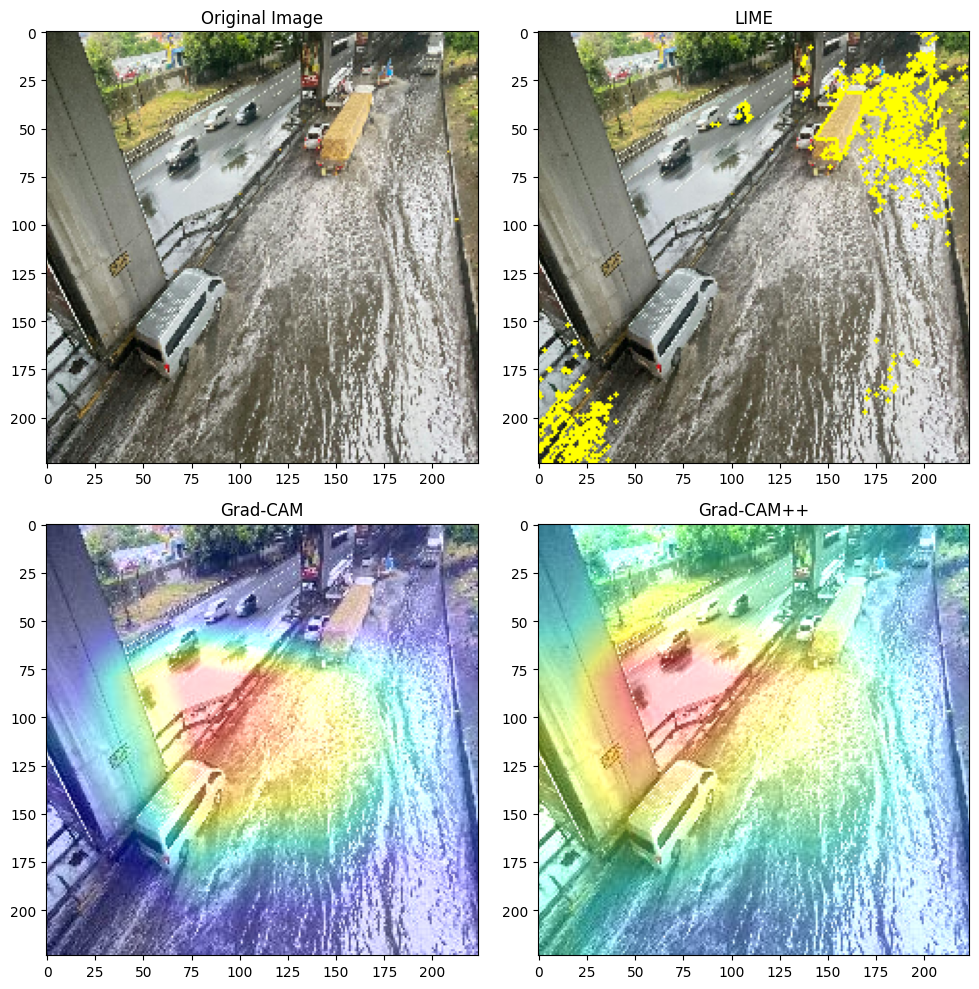

1/1 [==============================] - 0s 428ms/step

✓ Model Output ==> Flood


In [ ]:
img = url_to_image('https://1cms-img.imgix.net/rain-floods-Metro-Manila.jpg?auto=compress')
plot_XAI(img, model)
predict_image_class(img, model)